# Audio Cats And Dogs  

---
แยกเสียง Cat และ Dog

*   จาก Dataset : Audio Cats And Dogs [https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs](https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs)
*   โดย ทดลองสร้างโมเดล ANN และโมเดล CNN






นางสาวปฤณพร ชูแก้ว 6410210190



# การเตรียมข้อมูล (Preparing Data)



##  feature extraction

In [1]:
#อนุญาตการเข้าถึง Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
# import ไลบรารีที่จำเป็น
import os
import glob
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# ตั้งค่าเริ่มต้นสำหรับความสามารถในการทำซ้ำของการทดสอบ
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Helper Classes


In [64]:
FRAME_LENGTH = 255
FRAME_STEP = 128

#ใช้คลาส Spectrogram เพื่อสร้างสเปกโตรแกรมจากรูปคลื่นและรับฟังก์ชันตัวช่วยสำหรับการสร้างพล็อตสเปกโตรแกรม
class Spectrogram():

  def __init__(self):
    pass

  """
    Returns the spectrogram of the waveform.
  """
  def get_spectrogram(self, waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  """
    Returns the plot data of the spectrogram.
  """
  def plot_spectrogram(self, spectrogram, ax):
    if (len(spectrogram.shape) > 2):
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [65]:
BATCH_SIZE = 32
OUTPUT_SEQUENCE_LENGTH = 16000
TRAIN_DATASET = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train'
VALIDATION_DATASET = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test'

#สร้างคลาส Audio Dataloader เพื่อช่วยในการสร้างชุดการฝึก การตรวจสอบ และการทดสอบจากไฟล์เสียง
class AudioDataLoader():

  def __init__(self):
    pass

  """
    Returns the training dataset.
  """
  def get_training_dataset_and_class_names(self):
    train_ds = tf.keras.utils.audio_dataset_from_directory(
      TRAIN_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    class_names = train_ds.class_names
    train_ds = train_ds.map(self._squeeze, tf.data.AUTOTUNE)
    return train_ds, class_names

  """
    Returns the validation and test datasets.
  """
  def get_validation_and_test_datasets(self):
    validation_ds = tf.keras.utils.audio_dataset_from_directory(
      VALIDATION_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    validation_ds = validation_ds.map(self._squeeze, tf.data.AUTOTUNE)
    validation_ds, test_ds = self._get_test_dataset(validation_ds)

    return validation_ds, test_ds

  """
    Returns the test dataset.
  """
  def _get_test_dataset(self, validation_dataset):
    validation_dataset = validation_dataset.shard(num_shards=2, index=0)
    test_dataset = validation_dataset.shard(num_shards=2, index=1)
    return validation_dataset, test_dataset

  """
    Squeezes the waveform dimension.
  """
  def _squeeze(self, waveforms, labels):
    waveforms = tf.squeeze(waveforms, axis=-1)
    return waveforms, labels

In [66]:
#Load Audio Datasets
dataloader = AudioDataLoader()
train_ds, class_names = dataloader.get_training_dataset_and_class_names()
validation_ds, test_ds = dataloader.get_validation_and_test_datasets()

Found 210 files belonging to 2 classes.
Found 67 files belonging to 2 classes.


### ตรวจสอบชุดข้อมูลเสียง

In [67]:
# ตรวจสอบชื่อคลาส classnames
print(class_names)

['cat', 'dog']


In [68]:
for waveforms, labels in train_ds.take(1):
  print(waveforms.shape)
  print(labels.shape)

(32, 16000)
(32,)


In [69]:
import os

# แสดงชื่อไฟล์ข้อมูลในโฟลเดอร์ train/cat
train_cat_files = glob.glob(os.path.join(TRAIN_DATASET, 'cat', '*.wav'))
print("Training cat files:")
for file_path in train_cat_files[:10]:  # แสดงเพียง 10 ตัวอย่างเท่านั้น
    print(file_path)

# แสดงชื่อไฟล์ข้อมูลในโฟลเดอร์ test/cats
validation_cat_files = glob.glob(os.path.join(VALIDATION_DATASET, 'dogs', '*.wav'))
print("\nValidation cat files:")
for file_path in validation_cat_files[:10]:  # แสดงเพียง 10 ตัวอย่างเท่านั้น
    print(file_path)


Training cat files:
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_11.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_141.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_146.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_13.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_123.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_106.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_113.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_120.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_105.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/train/cat/cat_121.wav

Validation cat files:
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_78.wav
/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_8.wav
/content/drive/MyDrive/Audio Cats and Dogs/cat

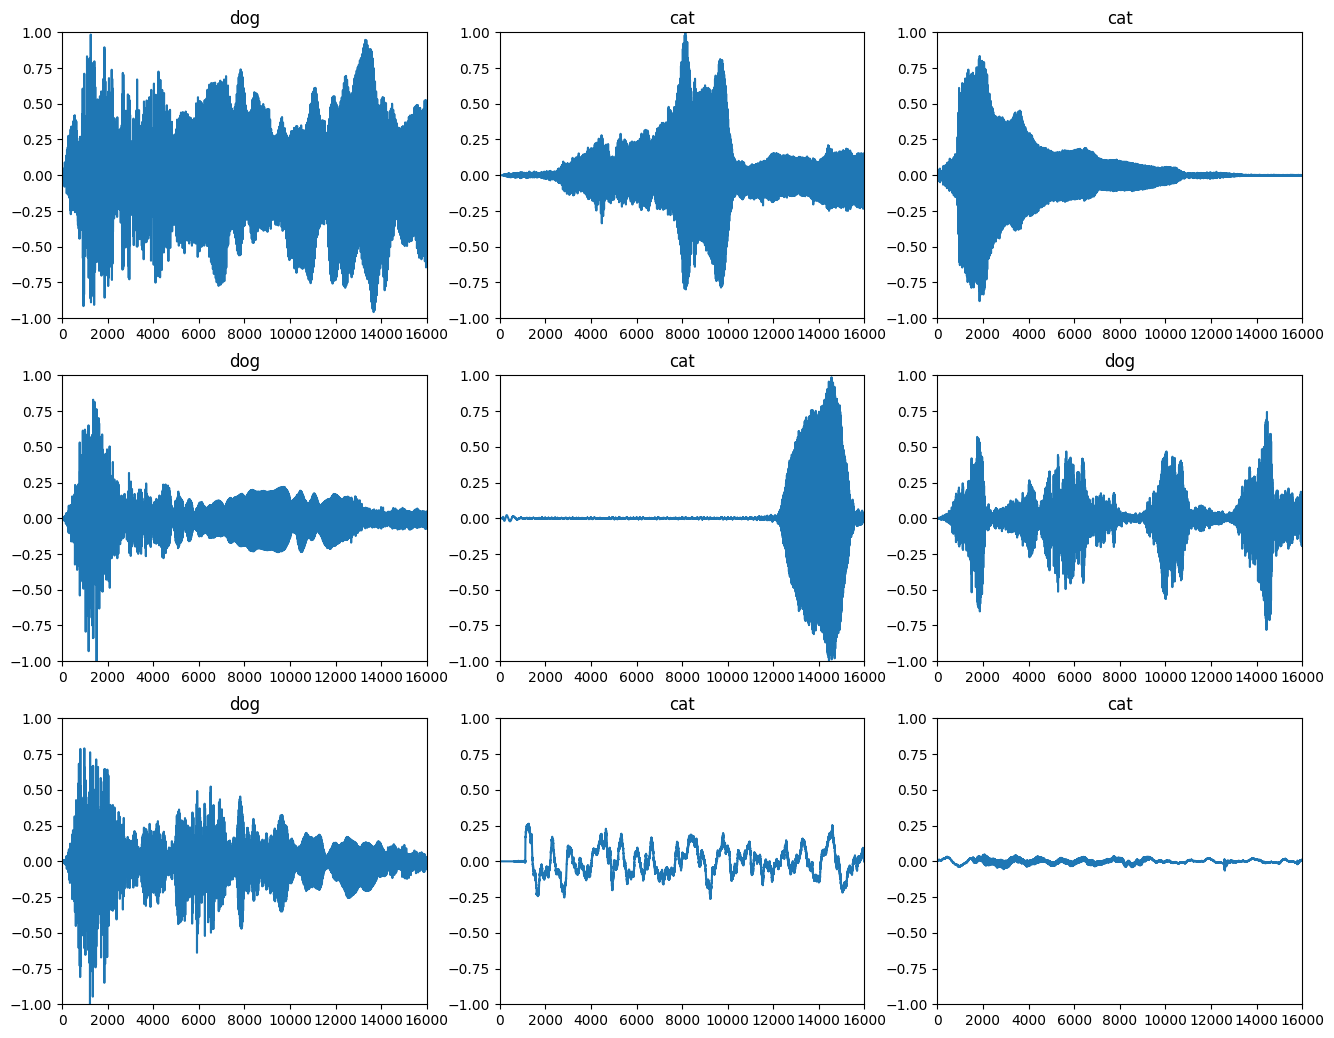

In [70]:
# พล็อตคลื่น waveforms
plt.figure(figsize=(16,9))
plt.subplots_adjust(bottom=-0.2)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.plot(waveforms[i].numpy())
  plt.title(class_names[labels[i]])
  plt.axis([0, 16000, -1, 1])

In [71]:
#สร้าง Spectrograms จาก Waveforms
spec = Spectrogram()

In [72]:
for j in range(6):
  label = class_names[labels[j]]
  waveform = waveforms[j]
  spectrogram = spec.get_spectrogram(waveform)
  print(f"\nLabel: {label}")
  print(f"Spectrogram Shape: {spectrogram.shape}\n")

  display.display(display.Audio(waveform, rate=16000))


Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)



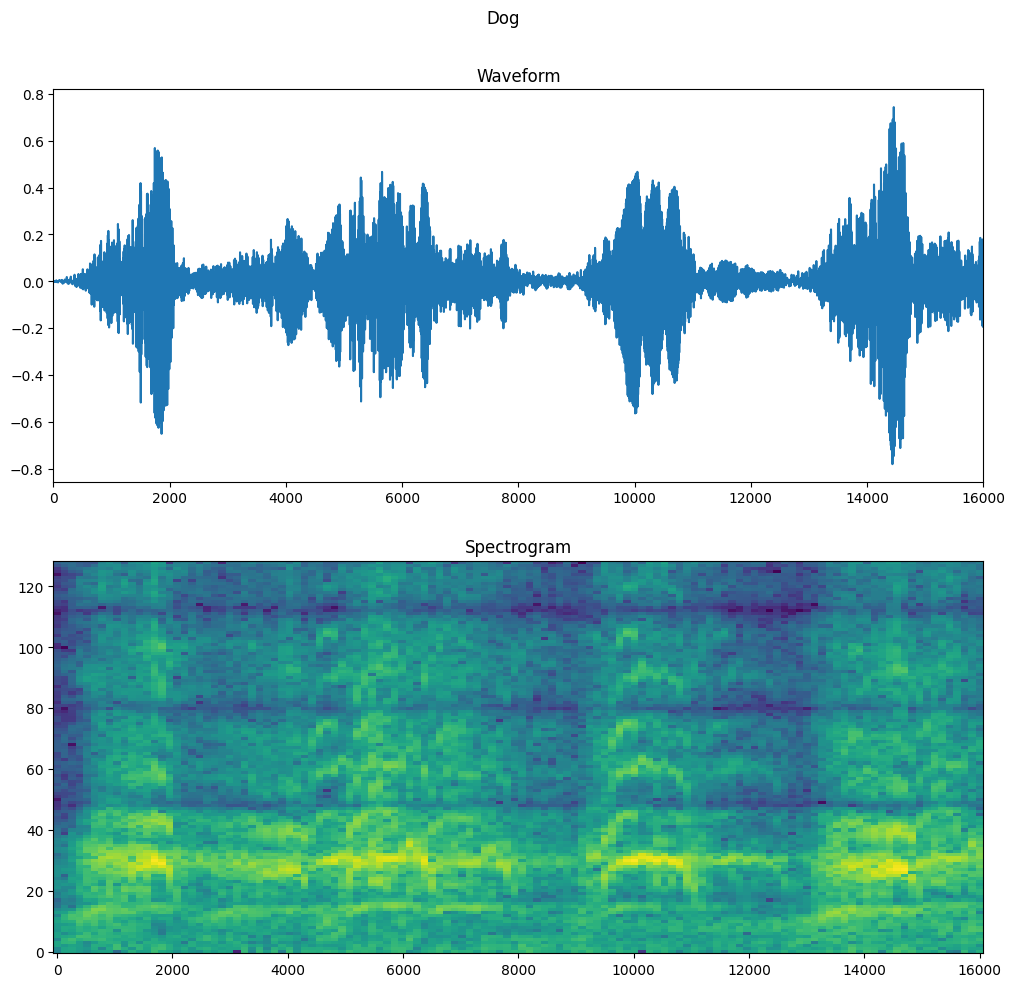

In [73]:
fig, axes = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(bottom=-0.2)

timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

spec.plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# Artificial Neural Network (ANN) Model

In [74]:
# สร้างชุดข้อมูล Spectrogram ที่จะใช้ใน ANN

class Spectrogram():

    def __init__(self):
        pass

    """
    Returns the spectrogram of the waveform.
    """
    def get_spectrogram(self, waveform):
        spectrogram = tf.signal.stft(
            waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
        spectrogram = tf.abs(spectrogram)
        spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram

    """
    Returns the plot data of the spectrogram.
    """
    def plot_spectrogram(self, spectrogram, ax):
        if (len(spectrogram.shape) > 2):
            assert len(spectrogram.shape) == 3
            spectrogram = np.squeeze(spectrogram, axis=-1)

        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)


def generate_spectrogram_dataset(dataset, spectrogram_generator):
    spectrogram_dataset = dataset.map(lambda x, y: (spectrogram_generator.get_spectrogram(x), y))
    return spectrogram_dataset

In [75]:
# สร้าง instance ของ Spectrogram class
spectrogram_generator = Spectrogram()

In [76]:
# สร้างชุดข้อมูลสเปกโตรแกรมสำหรับชุดข้อมูลการฝึกอบรม การตรวจสอบ และการทดสอบ
train_spectrogram_ds = generate_spectrogram_dataset(train_ds, spectrogram_generator)
validation_spectrogram_ds = generate_spectrogram_dataset(validation_ds, spectrogram_generator)
test_spectrogram_ds = generate_spectrogram_dataset(test_ds, spectrogram_generator)

In [77]:
#ตอนนี้มีชุดข้อมูลสเปกโตรแกรมที่พร้อมใช้ใน ANN แล้ว
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
  break

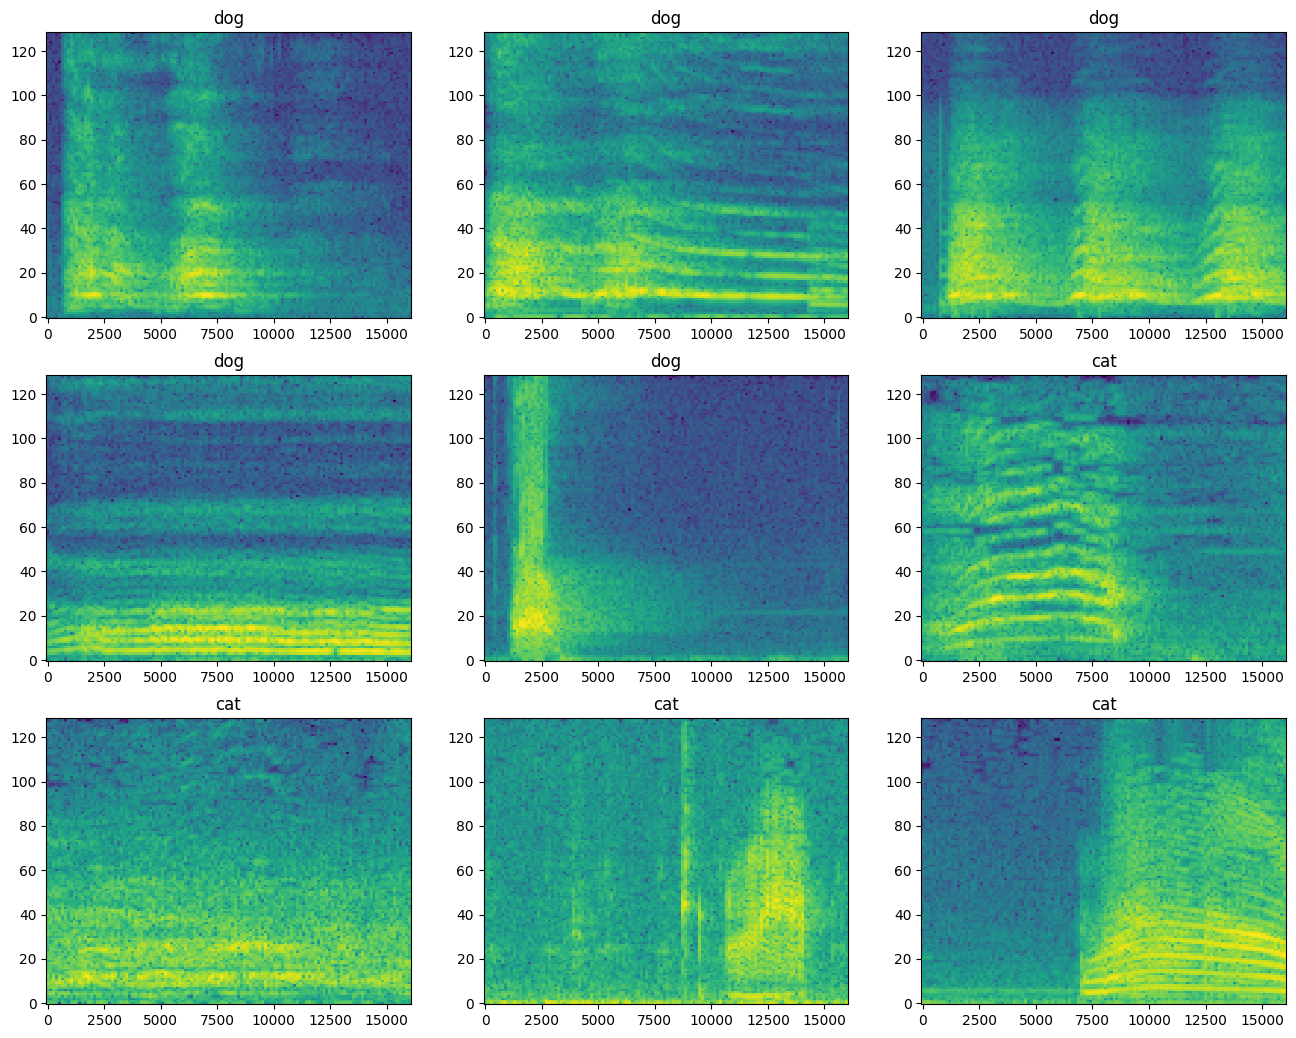

In [78]:
# พล็อตสเปกโตรแกรมบางส่วนเพื่อตรวจสอบว่าดูถูกต้อง

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_labels[i].numpy()])

plt.show()

train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [79]:
# Create the ANN Model
input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(class_names)

normalization = tf.keras.layers.Normalization()

# ปรับสถานะของเลเยอร์ให้เข้ากับสเปกโตรแกรม
# ด้วย `การทำให้เป็นมาตรฐาน.adapt`
normalization.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Flatten(),
    normalization,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.summary()

(124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15996)             0         
                                                                 
 normalization_2 (Normaliza  (1, 1, None, 15996)       3         
 tion)                                                           
                                                                 
 dense_4 (Dense)             (1, 1, None, 128)         2047616   
                                                                 
 dropout_3 (Dropout)         (1, 1, None, 128)         0         
                                                                 
 dense_5 (Dense)             (1, 1, None, 2)           258       
                                                                 
Total params: 2047877 (7.81 MB)
Trainable params: 2047874 (7.81 MB)
Non-trainable params: 3 (16.00 Byte)
_

In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Train Model

In [81]:
EPOCHS = 30

history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 3s 365ms/step - loss: 2.5365 - accuracy: 0.6762 - val_loss: 1.2273 - val_accuracy: 0.8286
Epoch 2/30
7/7 [==============================] - 1s 75ms/step - loss: 1.0453 - accuracy: 0.8381 - val_loss: 1.1628 - val_accuracy: 0.8857
Epoch 3/30
7/7 [==============================] - 1s 88ms/step - loss: 0.6307 - accuracy: 0.8476 - val_loss: 0.9989 - val_accuracy: 0.8857
Epoch 4/30
7/7 [==============================] - 0s 69ms/step - loss: 0.2390 - accuracy: 0.9000 - val_loss: 1.0114 - val_accuracy: 0.8571
Epoch 5/30
7/7 [==============================] - 1s 87ms/step - loss: 0.1973 - accuracy: 0.9286 - val_loss: 1.0041 - val_accuracy: 0.8571
Epoch 6/30
7/7 [==============================] - 1s 100ms/step - loss: 0.1995 - accuracy: 0.9333 - val_loss: 0.9787 - val_accuracy: 0.8571
Epoch 7/30
7/7 [==============================] - 1s 132ms/step - loss: 0.1879 - accuracy: 0.9333 - val_loss: 1.0942 - val_accuracy: 0.8571
Epoch 8/30
7/7 [===================

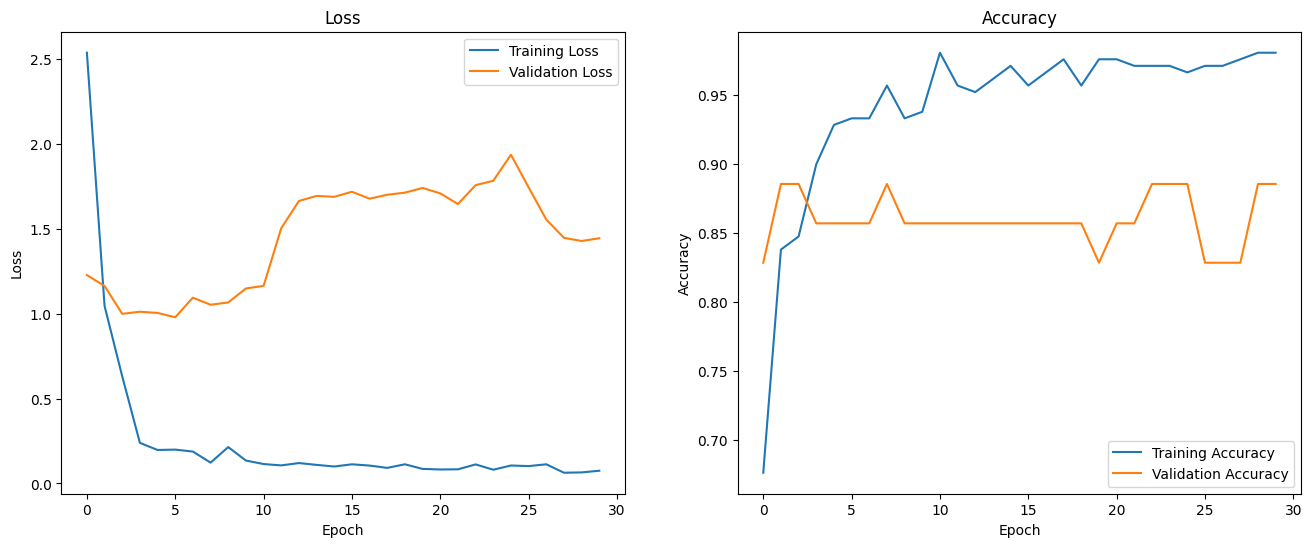

In [82]:
### **Classification Report**

# Extract metrics from history
metrics = history.history

# Plot loss and accuracy
plt.figure(figsize=(16, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Training Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

## Predict

In [83]:
# Perform predictions on the test dataset
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 1s 750ms/step


In [84]:
# Convert y_pred to labels
y_pred_labels = tf.argmax(y_pred, axis=1)

In [85]:
import tensorflow as tf
# Concatenate the true labels from the test dataset
y_test = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

In [86]:
# Convert y_true to numpy array
y_test_np = y_test.numpy()

# Convert y_pred_labels to numpy array
y_pred_labels_np = y_pred_labels.numpy()

## Model Evaluation

In [87]:
evaluation_results = model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 20ms/step - loss: 5.1657e-06 - accuracy: 1.0000


1/1 [==============================] - 0s 18ms/step - loss: 5.1657e-06 - accuracy: 1.0000
Test Loss: 5.165695711184526e-06
Test Accuracy: 1.0


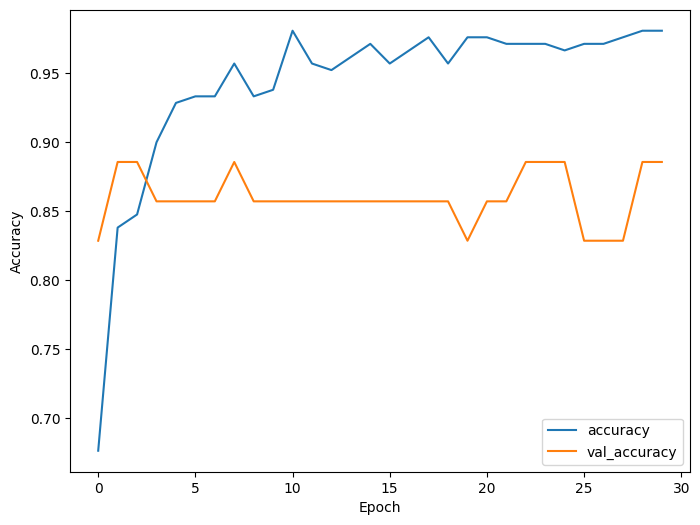

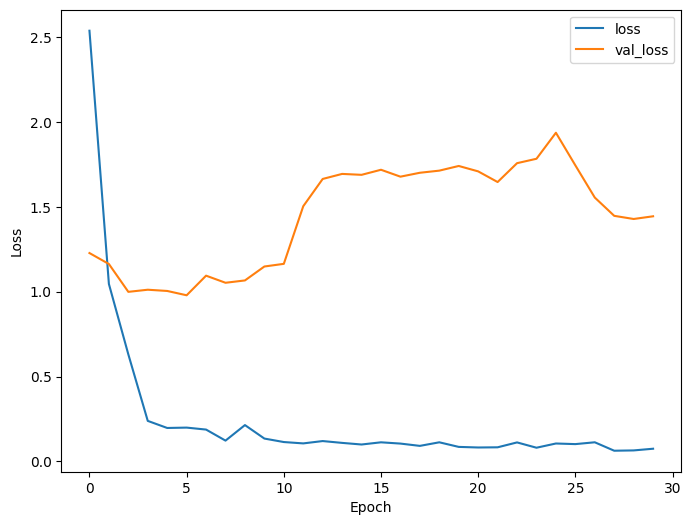

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_spectrogram_ds, return_dict=True)

# Print the evaluation results
print("Test Loss:", evaluation_results['loss'])
print("Test Accuracy:", evaluation_results['accuracy'])

# Plot the evaluation results
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## Accuracy Score

In [89]:
# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_spectrogram_ds, return_dict=True)

# Print the evaluation results
print("Test Loss:", evaluation_results['loss'])
print("Test Accuracy:", evaluation_results['accuracy']*100)

1/1 [==============================] - 0s 19ms/step - loss: 5.1657e-06 - accuracy: 1.0000
Test Loss: 5.165695711184526e-06
Test Accuracy: 100.0


### Test the Model

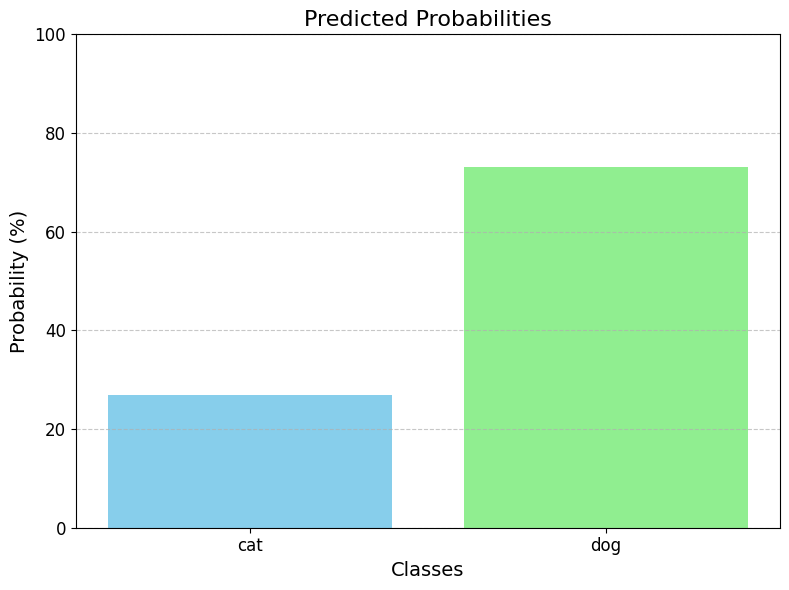

x_labels: ['cat', 'dog']
prediction_probabilities: [[[26.894144 73.10586 ]]]


In [90]:
#ทดสอบโมเดล
#จากไฟล์ใน test set

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# Read the audio file
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_15.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

# Get the spectrogram
x = spec.get_spectrogram(x)
x = x[tf.newaxis, ...]

# Perform prediction
prediction = model(x)

# Convert prediction probabilities to numpy array
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy()

# Define class labels
x_labels = ['cat', 'dog']




# Display the waveform
display.display(display.Audio(waveform, rate=16000))

# Plotting the predicted probabilities
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

print("x_labels:", x_labels)
print("prediction_probabilities:", prediction_probabilities * 100)


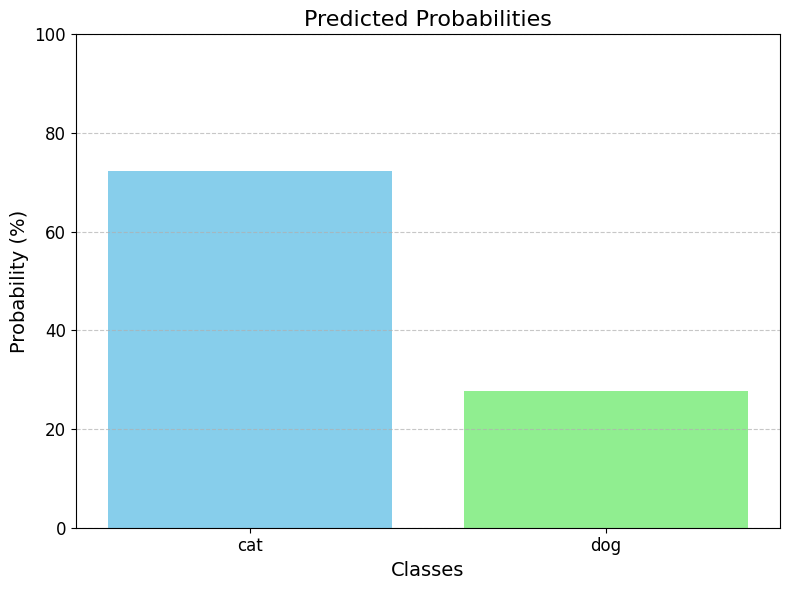

x_labels: ['cat', 'dog']
prediction_probabilities: [[[72.20623  27.793766]]]


In [91]:
# ทดสอบโมเดล
# ด้วยไฟล์เสียงใหม่

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# Read the audio file
x = '/content/drive/MyDrive/Audio Cats and Dogs/new_test_audio1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

# Get the spectrogram
x = spec.get_spectrogram(x)
x = x[tf.newaxis, ...]

# Perform prediction
prediction = model(x)

# Convert prediction probabilities to numpy array
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy()

# Define class labels
x_labels = ['cat', 'dog']




# Display the waveform
display.display(display.Audio(waveform, rate=16000))

# Plotting the predicted probabilities
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

print("x_labels:", x_labels)
print("prediction_probabilities:", prediction_probabilities * 100)


# Convolutional Neural Network (CNN) Model

In [43]:
#สร้างชุดข้อมูล Spectrogram เพื่อใช้ใน CNN

train_spectrogram_ds = train_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

validation_spectrogram_ds = validation_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_spectrogram_ds = test_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [44]:
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
  break

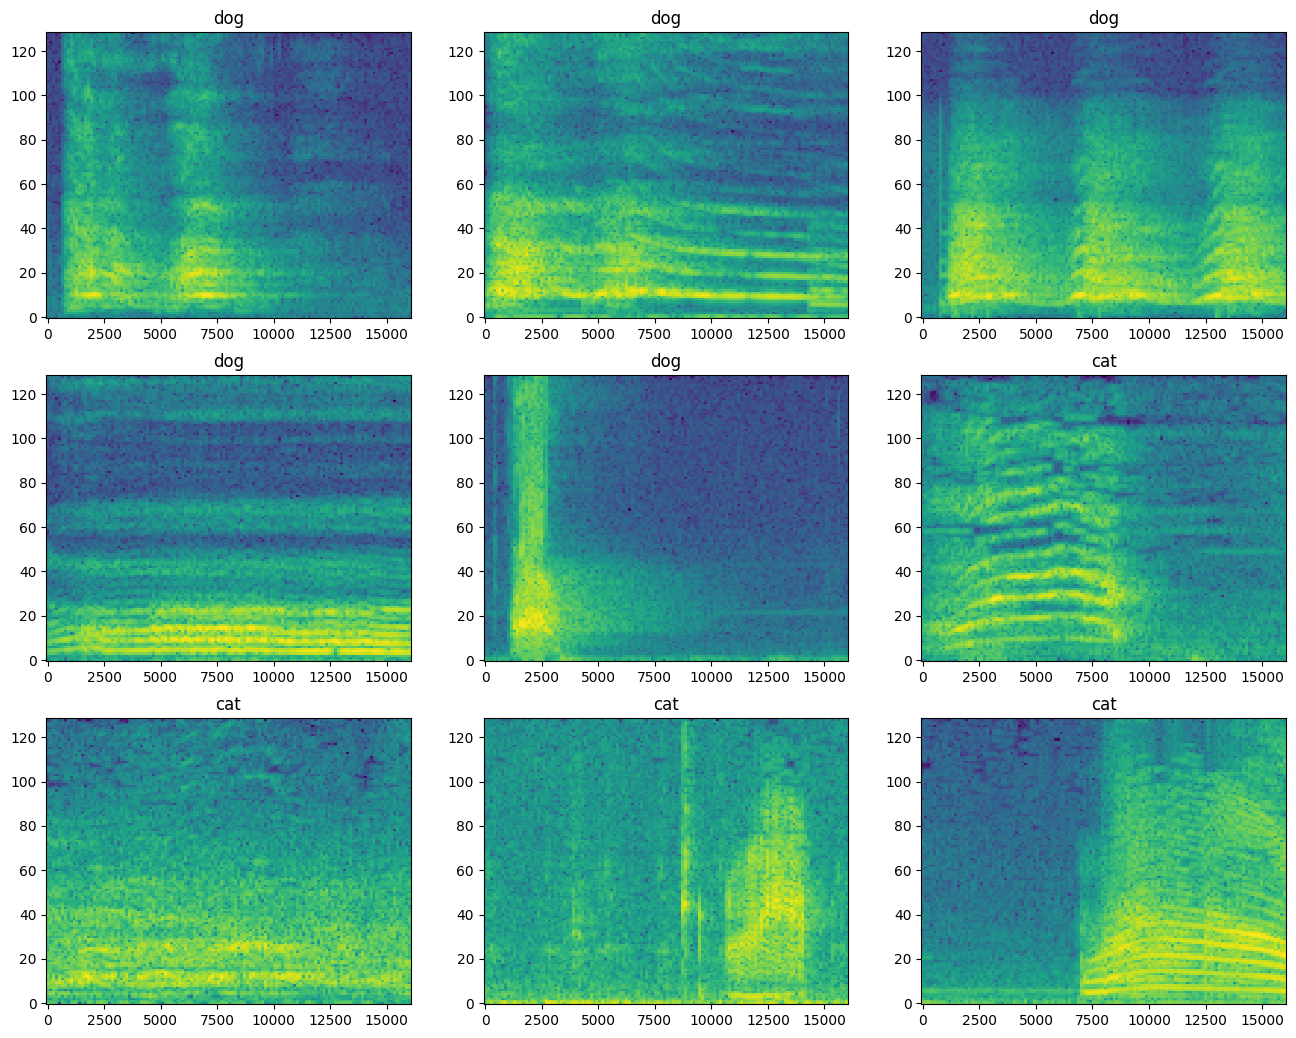

In [45]:
#พล็อตสเปกโตรแกรมบางส่วนเพื่อตรวจสอบว่าดูถูกต้อง

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_labels[i].numpy()])

plt.show()

In [46]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [47]:
#Create the CNN Model

input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(class_names)

normalization = tf.keras.layers.Normalization()

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
normalization.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    normalization,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels)
])

model.summary()

(124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 

In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Train Model

In [49]:
EPOCHS = 30

history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/30
7/7 [==============================] - 6s 454ms/step - loss: 0.5260 - accuracy: 0.7190 - val_loss: 0.3552 - val_accuracy: 0.8286
Epoch 2/30
7/7 [==============================] - 1s 177ms/step - loss: 0.3853 - accuracy: 0.8571 - val_loss: 0.3215 - val_accuracy: 0.9143
Epoch 3/30
7/7 [==============================] - 1s 171ms/step - loss: 0.3082 - accuracy: 0.8857 - val_loss: 0.3041 - val_accuracy: 0.8857
Epoch 4/30
7/7 [==============================] - 1s 166ms/step - loss: 0.2201 - accuracy: 0.9048 - val_loss: 0.3538 - val_accuracy: 0.9143
Epoch 5/30
7/7 [==============================] - 2s 274ms/step - loss: 0.1845 - accuracy: 0.9286 - val_loss: 0.4275 - val_accuracy: 0.8857
Epoch 6/30
7/7 [==============================] - 2s 256ms/step - loss: 0.2022 - accuracy: 0.9190 - val_loss: 0.3648 - val_accuracy: 0.8857
Epoch 7/30
7/7 [==============================] - 1s 166ms/step - loss: 0.1846 - accuracy: 0.9381 - val_loss: 0.4062 - val_accuracy: 0.9143
Epoch 8/30
7/7 [====

Text(0.5, 0, 'Epoch')

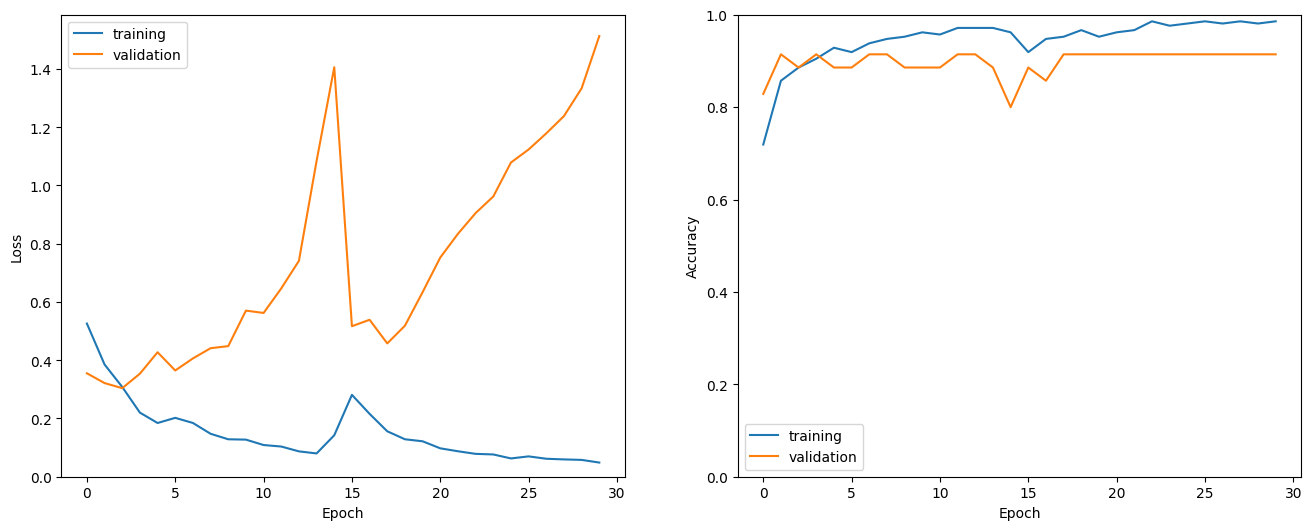

In [50]:
#Classification Report
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

## Predict

In [51]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 1s 547ms/step


In [52]:
y_pred = tf.argmax(y_pred, axis=1)

In [53]:
y_test = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

## Model Evaluation

In [54]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 17ms/step - loss: 4.8828e-04 - accuracy: 1.0000


{'loss': 0.0004882811044808477, 'accuracy': 1.0}

### Confusion matrix

In [55]:
#Creating the Confusion matrix
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_pred)
cm

array([[3]])

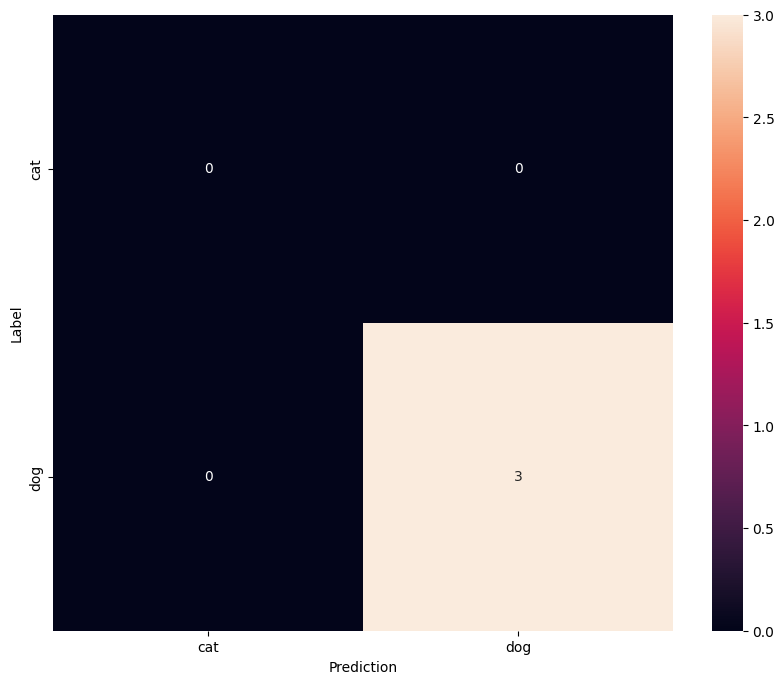

In [56]:
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Accuracy Score

In [57]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy score:", accuracy)

Accuracy score: 100.0


## Test the Model

cat: 0.00%
dog: 100.00%


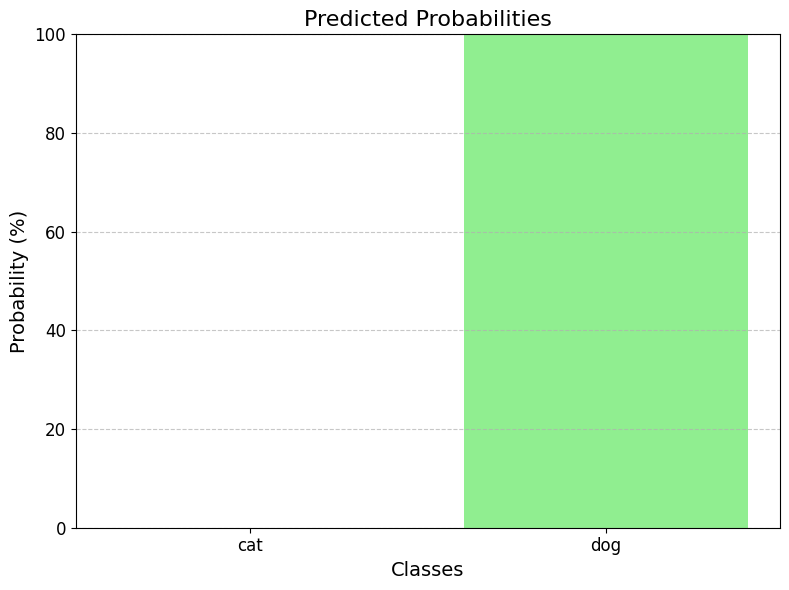

In [58]:
#ทดสอบโมเดล
#จากไฟล์ใน test set

x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_15.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]
display.display(display.Audio(waveform, rate=16000))


prediction = model(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage
class_labels = ['cat', 'dog']  # ระบุชื่อคลาสของแต่ละ index ใน prediction_probabilities
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


cat: 100.00%
dog: 0.00%


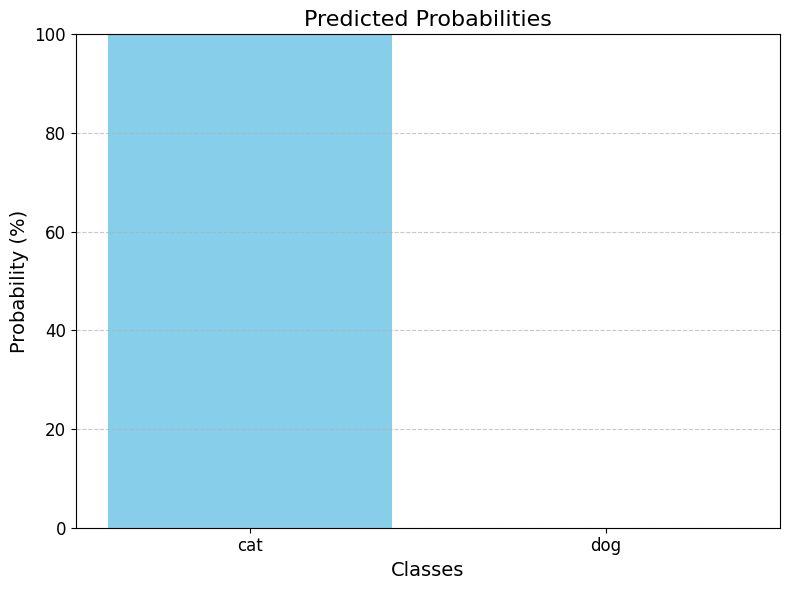

In [59]:
# ทดสอบโมเดล
# ด้วยไฟล์เสียงใหม่

x = '/content/drive/MyDrive/Audio Cats and Dogs/new_test_audio1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]
display.display(display.Audio(waveform, rate=16000))


prediction = model(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage
class_labels = ['cat', 'dog']  # ระบุชื่อคลาสของแต่ละ index ใน prediction_probabilities
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


# Cross Validation

## Dog Audio

**เปรียบเทียบการทำนายเสียงของ Cat ระหว่างโมเดล ANN และ CNN ว่าโมเดลใดทำนายได้ถูกต้องและแม่นยำมากที่สุด **

โมเดล ANN ของไฟล์เสียงที่เป็น เสียงของ Dog (ทดลองไฟล์เสียงเดียวกันทั้ง 2 โมเดล)

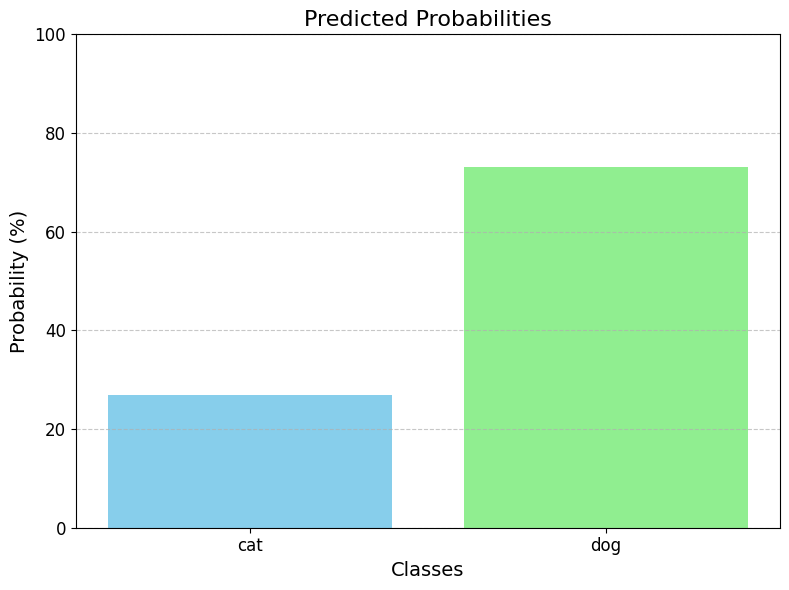

x_labels: ['cat', 'dog']
prediction_probabilities: [[[26.894144 73.10586 ]]]


In [92]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# Read the audio file
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_64.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

# Get the spectrogram
x = spec.get_spectrogram(x)
x = x[tf.newaxis, ...]

# Perform prediction
prediction = model(x)

# Convert prediction probabilities to numpy array
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy()

# Define class labels
x_labels = ['cat', 'dog']




# Display the waveform
display.display(display.Audio(waveform, rate=16000))

# Plotting the predicted probabilities
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

print("x_labels:", x_labels)
print("prediction_probabilities:", prediction_probabilities * 100)


โมเดล CNN ของไฟล์เสียงที่เป็น เสียงของ Dog (ทดลองไฟล์เสียงเดียวกันทั้ง 2 โมเดล)

cat: 0.00%
dog: 100.00%


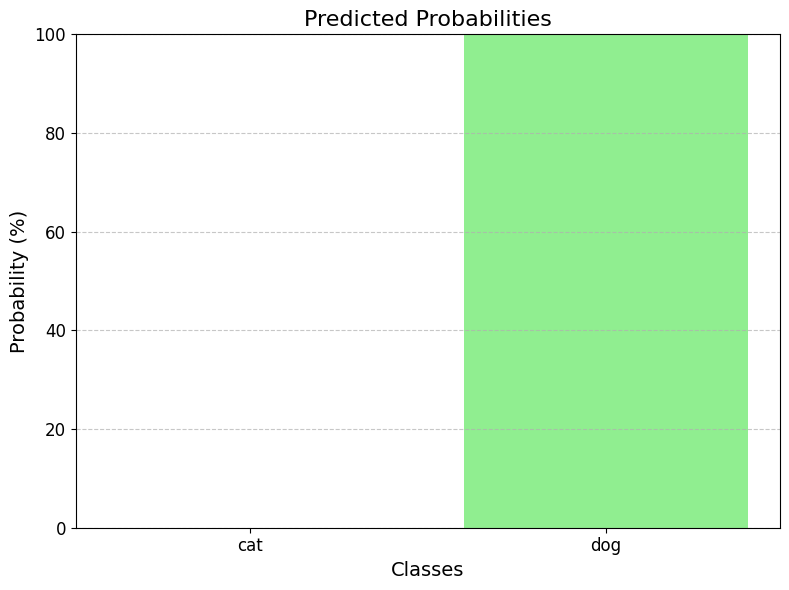

In [62]:
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_64.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]
display.display(display.Audio(waveform, rate=16000))


prediction = model(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage
class_labels = ['cat', 'dog']  # ระบุชื่อคลาสของแต่ละ index ใน prediction_probabilities
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## Cat Audio

**เปรียบเทียบการทำนายเสียงของ Cat ระหว่างโมเดล ANN และ CNN ว่าโมเดลใดทำนายได้ถูกต้องและแม่นยำมากที่สุด **

โมเดล ANN ของไฟล์เสียงที่เป็น เสียงของ Cat (ทดลองไฟล์เสียงเดียวกันทั้ง 2 โมเดล)

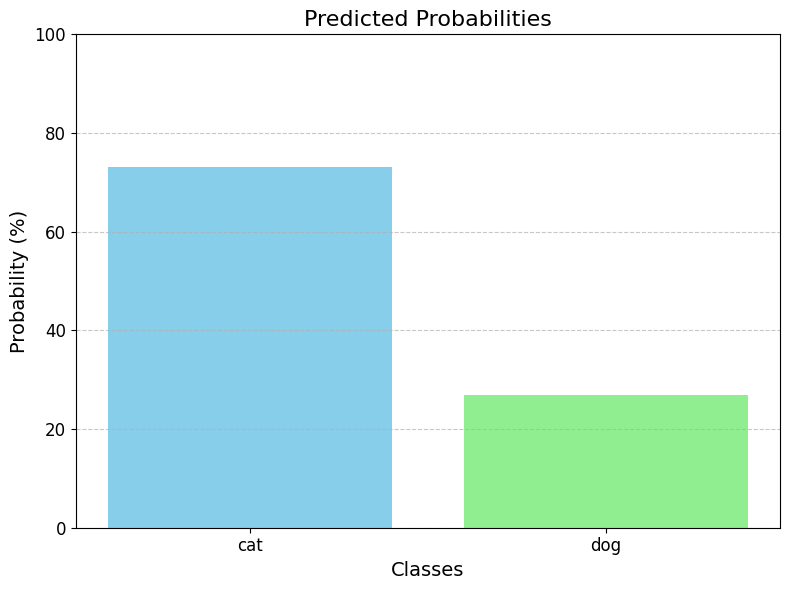

x_labels: ['cat', 'dog']
prediction_probabilities: [[[73.10586  26.894144]]]


In [93]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# Read the audio file
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/cats/cat_130.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

# Get the spectrogram
x = spec.get_spectrogram(x)
x = x[tf.newaxis, ...]

# Perform prediction
prediction = model(x)

# Convert prediction probabilities to numpy array
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy()

# Define class labels
x_labels = ['cat', 'dog']




# Display the waveform
display.display(display.Audio(waveform, rate=16000))

# Plotting the predicted probabilities
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

print("x_labels:", x_labels)
print("prediction_probabilities:", prediction_probabilities * 100)


โมเดล CNN ของไฟล์เสียงที่เป็น เสียงของ Cat (ทดลองไฟล์เสียงเดียวกันทั้ง 2 โมเดล)

cat: 100.00%
dog: 0.00%


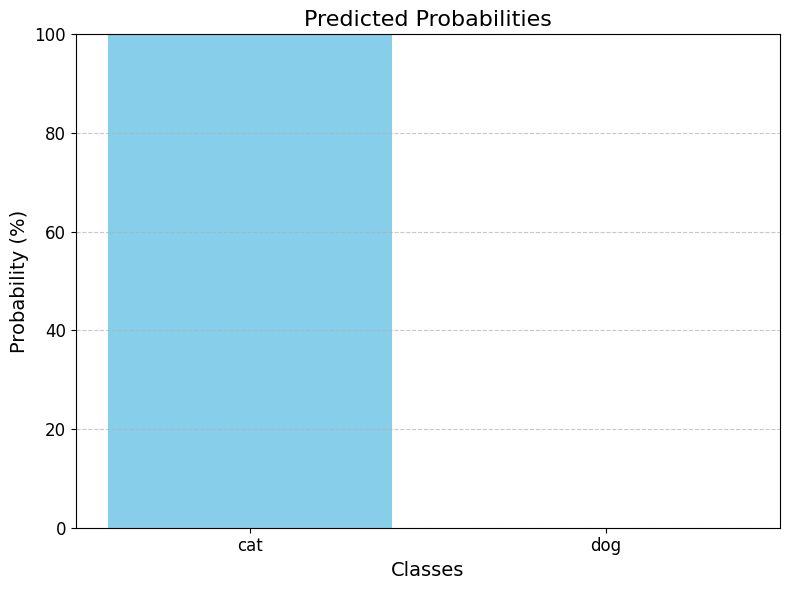

In [61]:
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/cats/cat_130.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]
display.display(display.Audio(waveform, rate=16000))


prediction = model(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage
class_labels = ['cat', 'dog']  # ระบุชื่อคลาสของแต่ละ index ใน prediction_probabilities
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']  # Define colors for the bars
plt.bar(x_labels, np.ravel(prediction_probabilities * 100), color=bar_colors)  # Flatten the array if necessary
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines with dashed style and reduced opacity
plt.xticks(fontsize=12)  # Adjust font size of x-axis ticks
plt.yticks(fontsize=12)  # Adjust font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


จะเห็นได้ว่าโมเดล CNN มีการทำนาย และให้ค่า Predicted Probabilities ที่ดีกว่าโมเดล ANN   ดังนั้น โมเดล CNN จึงมีการทำนายที่ดีกว่า

# การนำโมเดลไปใช้งาน (Deploy Model) Model ที่ดีที่สุด

บันทึกโมเดล CNN (โมเดลที่ดีกว่า)

In [60]:
import pickle

# บันทึกโมเดลลงในไฟล์
with open('/content/drive/MyDrive/Audio Cats and Dogs/Model/cnn_model.pickle', 'wb') as f:
    pickle.dump(model, f)


In [4]:
import pickle

# โหลดโมเดลจากไฟล์
with open('/content/drive/MyDrive/Audio Cats and Dogs/Model/cnn_model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)


In [5]:
FRAME_LENGTH = 255
FRAME_STEP = 128

#ใช้คลาส Spectrogram เพื่อสร้างสเปกโตรแกรมจากรูปคลื่นและรับฟังก์ชันตัวช่วยสำหรับการสร้างพล็อตสเปกโตรแกรม
class Spectrogram():

  def __init__(self):
    pass

  """
    Returns the spectrogram of the waveform.
  """
  def get_spectrogram(self, waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  """
    Returns the plot data of the spectrogram.
  """
  def plot_spectrogram(self, spectrogram, ax):
    if (len(spectrogram.shape) > 2):
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

ทดสอบโมเดล CNN ที่บันทึกแล้วโหลดมา สกัดคุณลักษณะ และ ทำนายผลลัพธ์

1/1 [==============================] - 0s 210ms/step


cat: 0.00%
dog: 100.00%


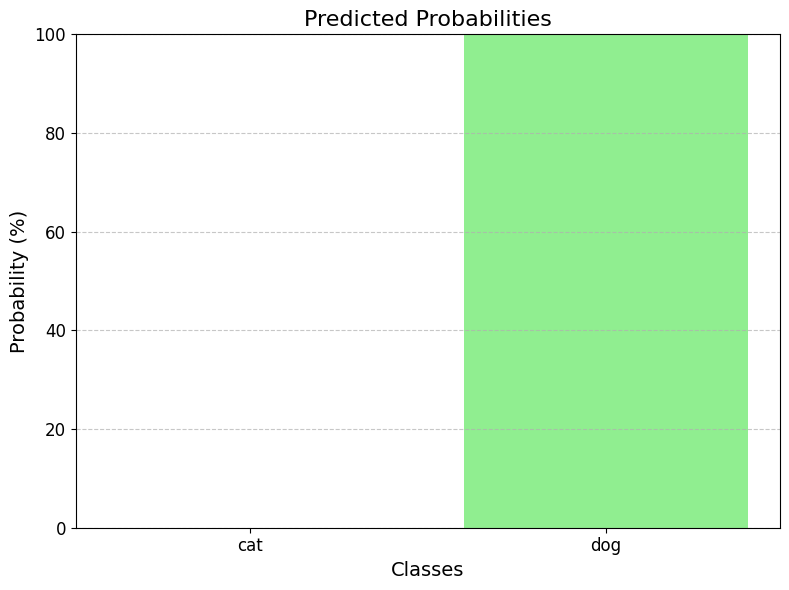

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import IPython.display as ipd


spec = Spectrogram()

# Load and preprocess the audio file for prediction
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/dogs/dog_barking_3.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

# Perform prediction
prediction = loaded_model.predict(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage

# Display the waveform
ipd.display(ipd.Audio(waveform.numpy(), rate=16000))

class_labels = ['cat', 'dog']
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

# Plot the predicted probabilities
x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']
plt.bar(x_labels, np.ravel(prediction_probabilities), color=bar_colors)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 22ms/step


cat: 99.91%
dog: 0.09%


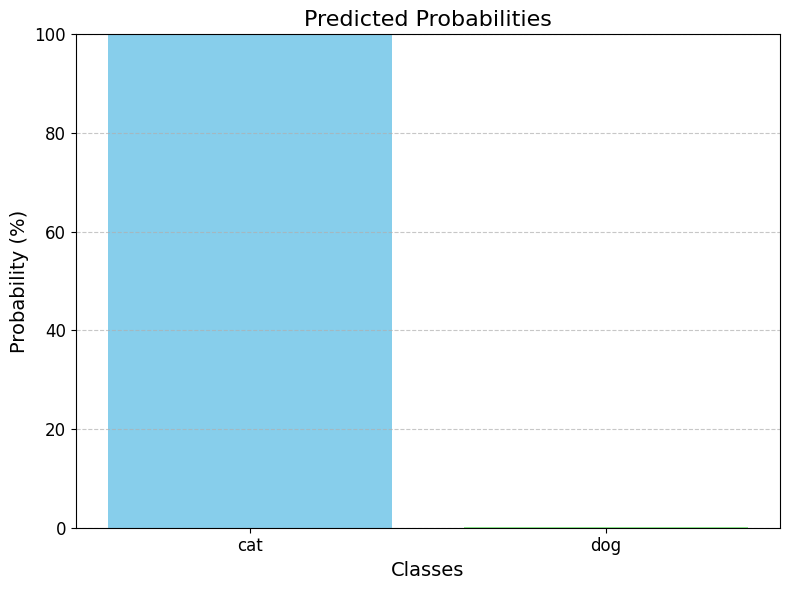

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import IPython.display as ipd


spec = Spectrogram()

# Load and preprocess the audio file for prediction
x = '/content/drive/MyDrive/Audio Cats and Dogs/cats_dogs/test/cats/cat_133.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

# Perform prediction
prediction = loaded_model.predict(x)
prediction_probabilities = tf.nn.softmax(prediction[0]).numpy() * 100  # Convert to numpy array and scale to percentage

# Display the waveform
ipd.display(ipd.Audio(waveform.numpy(), rate=16000))

class_labels = ['cat', 'dog']
for i, prob in enumerate(prediction_probabilities):
    print(f"{class_labels[i]}: {prob:.2f}%")

# Plot the predicted probabilities
x_labels = ['cat', 'dog']
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen']
plt.bar(x_labels, np.ravel(prediction_probabilities), color=bar_colors)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title('Predicted Probabilities', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
